# Import libraries and init

In [1]:
# import ROOT -- don't need this for now
import numpy as np
import pandas as pd
from collections import OrderedDict
import math

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 9})

import uproot # uproot needs to be last for some reason

In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [3]:
from functools import reduce
import operator

# Load ntuples from analyzer

Define parameters in separate block so can change them without loading files all over again

In [4]:
#masses = [('60p0','20p0'),('6p0','2p0'),('52p5','5p0'),('5p25','0p5')]
masses = [('60p0','20p0')]
printMasses = lambda mass: f'({float(mass[0].replace("p","."))-float(mass[1].replace("p","."))/2}, ' + \
                                f'{float(mass[0].replace("p","."))+float(mass[1].replace("p","."))/2}) GeV'
mchis = dict([(mass[0], printMasses(mass)) for mass in masses])
ctaus = [1,10, 100]#, 1000]

numCuts = np.arange(0,6)
labels = [ f'cut{cut}' for cut in numCuts ]
cutDescriptions = ['cut1: MET/MHT trigger fired (120 GeV)', \
                   'cut2: j1 pT > 120 GeV, <= 2j w/ pT > 30 GeV', \
                   'cut3: mu1 pT > 5 GeV, 0.1 < |dxy| < 700 cm', \
                   'cut4: mu2 pT > 5 GeV, 0.1 < |dxy| < 700 cm', \
                   r'cut5: $|\Delta\Phi$(MET, mu pair)| < 0.4'
                  ]

branchPath = 'SREffi_dsa'
baseDir = '/uscms/home/mreid/nobackup/signal_region/2018/pileup/'
fileName = lambda Mchi, dMchi, ctau: baseDir + f'pileup_trackquality_Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

Load signal files

In [5]:
numParams = len(masses)*len(ctaus)
countParam = 1

trees = OrderedDict({})
treesglobal = OrderedDict({})
genInfo = OrderedDict({})
numEvents = OrderedDict({})
for (Mchi, dMchi) in masses:
    countCtaus = 1
    trees[Mchi] = OrderedDict({})
    treesglobal[Mchi] = OrderedDict({})
    numEvents[Mchi] = OrderedDict({})
    genInfo[Mchi] = OrderedDict({})
    for ctau in ctaus:
        genInfo[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN/gen']
        trees[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))[branchPath + f'/cutsTree']
        treesglobal[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['SREffi_gbm' + f'/cutsTree']
        print(f'{countParam} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
        countParam += 1

1 of 3: /uscms/home/mreid/nobackup/signal_region/2018/pileup/pileup_trackquality_Mchi-60p0_dMchi-20p0_ctau-1.root
2 of 3: /uscms/home/mreid/nobackup/signal_region/2018/pileup/pileup_trackquality_Mchi-60p0_dMchi-20p0_ctau-10.root
3 of 3: /uscms/home/mreid/nobackup/signal_region/2018/pileup/pileup_trackquality_Mchi-60p0_dMchi-20p0_ctau-100.root


Create pandas dataframes for different physics objects now that uproot won't flatten them anymore
(does make code faster)

In [6]:
leadingJet = OrderedDict({}); MET = OrderedDict({});
muons = OrderedDict({}); vertex = OrderedDict({});
cuts = OrderedDict({}); cutsCrit = OrderedDict({});
checkmuons = OrderedDict({}); gen = OrderedDict({})
checkgmuons = OrderedDict({}); beamhalo = OrderedDict({});
for mchi in mchis:
    leadingJet[mchi] = OrderedDict({}); MET[mchi] = OrderedDict({});
    muons[mchi] = OrderedDict({}); vertex[mchi] = OrderedDict({});
    cuts[mchi] = OrderedDict({}); cutsCrit[mchi] = OrderedDict({});
    checkmuons[mchi] = OrderedDict({}); gen[mchi] = OrderedDict({})
    checkgmuons[mchi] = OrderedDict({}); beamhalo[mchi] = OrderedDict({});
    for ctau in ctaus:
        leadingJet[mchi][ctau] = trees[mchi][ctau].pandas.df(['recoPFJetPt','recoPFJetEta','recoPFJetPhi']).loc[(slice(None),0),slice(None)].reset_index(level=1)
        MET[mchi][ctau] = trees[mchi][ctau].pandas.df(['recoPFMetPt', 'recoPFMetPhi'])
        muons[mchi][ctau] = trees[mchi][ctau].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz']).reset_index(level=1)
        vertex[mchi][ctau] = trees[mchi][ctau].pandas.df(['recoDr','recoVxy','recoVz']).reset_index(level=1)
        cuts[mchi][ctau] = trees[mchi][ctau].pandas.df('cutsVec*')
        cutsCrit[mchi][ctau] = [ cuts[mchi][ctau][f'cutsVec[{cut}]'] == 1 for cut in numCuts ]
        checkmuons[mchi][ctau] = trees[mchi][ctau].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz','trackHits','trackPlanes','trackChi2','qualityTrack','isGenMatched','GenDR']).reset_index(level=1)
        checkgmuons[mchi][ctau] = treesglobal[mchi][ctau].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz','trackHits','trackPlanes','trackChi2','qualityTrack','isGenMatched','GenDR']).reset_index(level=1)
        beamhalo[mchi][ctau] = treesglobal[mchi][ctau].pandas.df(['fired','beamHaloHcal','beamHaloEcal','beamHaloCSC','beamHaloGlobal','beamHaloGlobalsuper','beamHaloCSCtight','trackHits','trackPlanes','trackChi2','qualityTrack']).reset_index(level=1)

Separately calculate the phi average angle between the two muons -- for use in DeltaPhi(MET, muon pair) -- since it takes a while

In [7]:
beamhalo['60p0']

OrderedDict([(1,
                      subentry  fired  beamHaloHcal  beamHaloEcal  beamHaloCSC  \
              entry                                                              
              0              0      0         False         False        False   
              0              1      0         False         False        False   
              0              2      0         False         False        False   
              1              0      0         False         False        False   
              1              1      0         False         False        False   
              1              2      0         False         False        False   
              2              0      0         False         False         True   
              2              1      0         False         False         True   
              2              2      0         False         False         True   
              3              0      0         False         False        False   

In [8]:
for mass in mchis:
    for ctau in ctaus:
        csc = beamhalo[mass][ctau]['beamHaloCSC'].mean()
        hcal = beamhalo[mass][ctau]['beamHaloHcal'].mean()
        ecal = beamhalo[mass][ctau]['beamHaloEcal'].mean()
        glob = beamhalo[mass][ctau]['beamHaloGlobal'].mean()
        globsuper = beamhalo[mass][ctau]['beamHaloGlobalsuper'].mean()
        csctight = beamhalo[mass][ctau]['beamHaloCSCtight'].mean()
        #print(csc,hcal,ecal,glob,globsuper,csctight)
        csc_trig = beamhalo[mass][ctau][beamhalo[mass][ctau]['fired']==1]['beamHaloCSC'].mean()
        hcal_trig = beamhalo[mass][ctau][beamhalo[mass][ctau]['fired']==1]['beamHaloHcal'].mean()
        ecal_trig = beamhalo[mass][ctau][beamhalo[mass][ctau]['fired']==1]['beamHaloEcal'].mean()
        glob_trig = beamhalo[mass][ctau][beamhalo[mass][ctau]['fired']==1]['beamHaloGlobal'].mean()
        globsuper_trig = beamhalo[mass][ctau][beamhalo[mass][ctau]['fired']==1]['beamHaloGlobalsuper'].mean()
        csctight_trig = beamhalo[mass][ctau][beamhalo[mass][ctau]['fired']==1]['beamHaloCSCtight'].mean()
    
        csc_qual = beamhalo[mass][ctau][beamhalo[mass][ctau]['qualityTrack']==1]['beamHaloCSC'].mean()
        hcal_qual = beamhalo[mass][ctau][beamhalo[mass][ctau]['qualityTrack']==1]['beamHaloHcal'].mean()
        ecal_qual = beamhalo[mass][ctau][beamhalo[mass][ctau]['qualityTrack']==1]['beamHaloEcal'].mean()
        glob_qual = beamhalo[mass][ctau][beamhalo[mass][ctau]['qualityTrack']==1]['beamHaloGlobal'].mean()
        globsuper_qual = beamhalo[mass][ctau][beamhalo[mass][ctau]['qualityTrack']==1]['beamHaloGlobalsuper'].mean()
        csctight_qual = beamhalo[mass][ctau][beamhalo[mass][ctau]['qualityTrack']==1]['beamHaloCSCtight'].mean()

        csc_qual_trig = beamhalo[mass][ctau][(beamhalo[mass][ctau]['qualityTrack']==1) & (beamhalo[mass][ctau]['fired']==1)]['beamHaloCSC'].mean()
        hcal_qual_trig = beamhalo[mass][ctau][(beamhalo[mass][ctau]['qualityTrack']==1) & (beamhalo[mass][ctau]['fired']==1)]['beamHaloHcal'].mean()
        ecal_qual_trig = beamhalo[mass][ctau][(beamhalo[mass][ctau]['qualityTrack']==1) & (beamhalo[mass][ctau]['fired']==1)]['beamHaloEcal'].mean()
        glob_qual_trig = beamhalo[mass][ctau][(beamhalo[mass][ctau]['qualityTrack']==1) & (beamhalo[mass][ctau]['fired']==1)]['beamHaloGlobal'].mean()
        globsuper_qual_trig = beamhalo[mass][ctau][(beamhalo[mass][ctau]['qualityTrack']==1) & (beamhalo[mass][ctau]['fired']==1)]['beamHaloGlobalsuper'].mean()
        csctight_qual_trig = beamhalo[mass][ctau][(beamhalo[mass][ctau]['qualityTrack']==1) & (beamhalo[mass][ctau]['fired']==1)]['beamHaloCSCtight'].mean()
        #print(csc_trig,hcal_trig,ecal_trig,glob_trig,globsuper_trig,csctight_trig)
        table= [[csc,hcal,ecal,glob,globsuper,csctight],
            [csc_trig,hcal_trig,ecal_trig,glob_trig,globsuper_trig,csctight_trig],
            [csc_qual,hcal_qual,ecal_qual,glob_qual,globsuper_qual,csctight_qual],
            [csc_qual_trig,hcal_qual_trig,ecal_qual_trig,glob_qual_trig,globsuper_qual_trig,csctight_qual_trig]]
        beam= pd.DataFrame(table, columns=['csc','hcal','ecal','glob','globsuper','csctight'])
        print(beam)

        csc      hcal  ecal      glob  globsuper  csctight
0  0.127457  0.150663   0.0  0.003359   0.000087  0.034665
1  0.128267  0.201387   0.0  0.003254   0.000081  0.035946
2  0.113894  0.150520   0.0  0.003221   0.000094  0.031468
3  0.115477  0.202228   0.0  0.003090   0.000075  0.032554
        csc      hcal  ecal      glob  globsuper  csctight
0  0.127602  0.144926   0.0  0.003513   0.000083  0.035375
1  0.124218  0.196726   0.0  0.003334   0.000090  0.035790
2  0.114676  0.144527   0.0  0.003299   0.000065  0.032090
3  0.111923  0.196457   0.0  0.003171   0.000073  0.032592
        csc      hcal  ecal      glob  globsuper  csctight
0  0.129457  0.146686   0.0  0.003557   0.000030  0.035332
1  0.129860  0.199315   0.0  0.003346   0.000011  0.035805
2  0.115114  0.145936   0.0  0.003339   0.000031  0.031604
3  0.115560  0.198648   0.0  0.003141   0.000015  0.032098


# Plot everything together

To plot individual plots separately, copy relevant block of code and replace "axes[i,j]" with "plt", and take note that some of the functions change name, e.g. axes[i,j].set_xlabel() --> plt.xlabel() and axes[i,j].set_ylim() --> plt.ylim().

The other option is to copy the block and add "fig, ax = plt.subplots(1,1)" at the top, and then do the replacement axes[i,j] --> ax elsewhere.

## Helper functions

In [9]:
insets = True
log = False
histtype ='step'
iheight="45%"
iwidth="35%"

def plot_inset(data, axis, kwargs={}):
    #if 'bins' not in kwargs: kwargs['bins'] = 10
    if 'histtype' not in kwargs: kwargs['histtype'] = histtype#build
    if insets:
        axins = inset_axes(axis, width=iwidth, height=iheight)
        for (cut,datum) in enumerate(data):
            ret = axins.hist(datum, **kwargs)
            if cut == 1:
                axins.set_ylim(100,1.1*max(ret[0]))
        return axins

def plot_full(data, axis, kwargs={}, labels = []):
    if 'bins' not in kwargs: kwargs['bins'] = 50
    if 'histtype' not in kwargs: kwargs['histtype'] = histtype
    if 'log' not in kwargs: kwargs['log'] = log
    for (cut,datum) in enumerate(data):
        ret = axis.hist(datum, label=(labels[cut] if len(labels) > 0 else ''), **kwargs)
        if cut == 0:
            axis.set_ylim(1, 1.5*max(ret[0]))
            
# Helper function to normalize angle differences to [-Pi, Pi]
# cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
def reducephi(row):
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

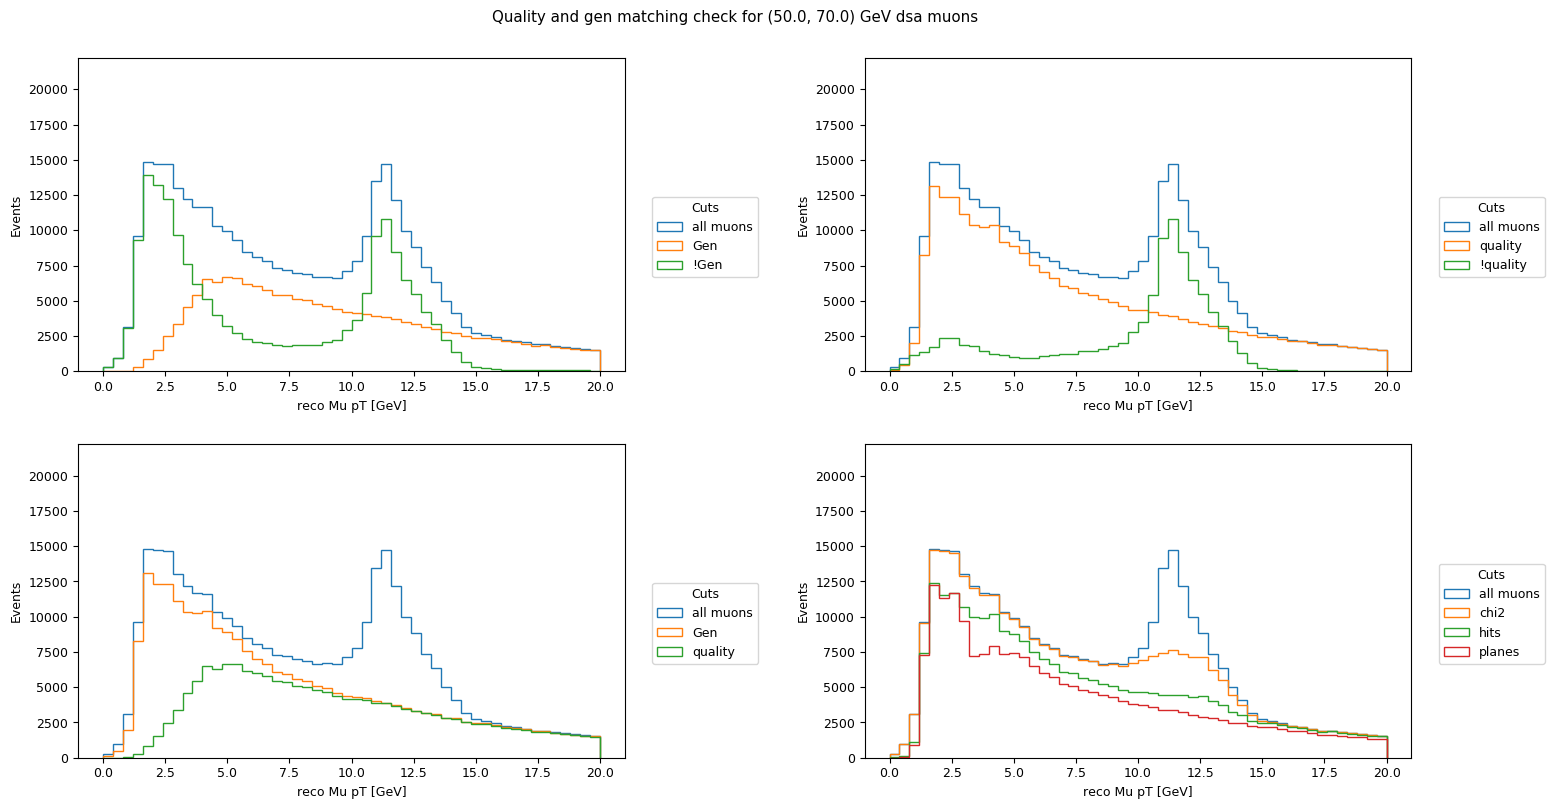

In [10]:
mchi = '60p0'
ctau = 10
### Make subplot axes
fig, axes = plt.subplots(2,2, figsize=(14,8))
plt.tight_layout(h_pad=4.0, w_pad=16.0)
for row in axes:
    for col in row:
        col.set_ylabel('Events')
        
fig.suptitle(f'Quality and gen matching check for {mchis[mchi]} dsa muons')
fig.subplots_adjust(top=0.92)

genlabels1 = ['all muons','Gen','!Gen']#, 'is gen and quality']   
genlabels2 = ['all muons','quality','!quality']#
genlabels3 = ['all muons','Gen','quality']#
### reco MET pT
axes[0,0].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['isGenMatched']==True]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['isGenMatched']==False]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[0,0], dict({'range':(0,20)}), labels=genlabels1)


axes[0,1].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['qualityTrack']==True]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['qualityTrack']==False]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[0,1], dict({'range':(0,20)}), labels=genlabels2)

axes[1,0].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['qualityTrack']==True]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['isGenMatched']==True]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[1,0], dict({'range':(0,20)}), labels=genlabels3)

genlabels4 = ['all muons','chi2','hits','planes']#
axes[1,1].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <10]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits']> 12]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes']> 2]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[1,1], dict({'range':(0,20)}), labels=genlabels4)

axes[0,0].legend(loc=(1.05,.3), title='Cuts');
axes[0,1].legend(loc=(1.05,.3), title='Cuts');
axes[1,0].legend(loc=(1.05,.3), title='Cuts');
axes[1,1].legend(loc=(1.05,.3), title='Cuts');

In [11]:
checkmuons[mchi][ctau].groupby('entry').nth(0).corr()

,subentry,recoPt,recoEta,recoPhi,recoDxy,recoDz,trackHits,trackPlanes,trackChi2,qualityTrack,isGenMatched,GenDR
subentry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recoPt,NaN,1.000000,-0.001450,0.000069,-0.008610,-0.000391,-0.002162,0.005040,-0.001011,0.009958,0.013168,-0.014427
recoEta,NaN,-0.001450,1.000000,0.000488,0.000656,0.000535,0.004505,0.005446,-0.000013,0.001885,0.006603,-0.003376
recoPhi,NaN,0.000069,0.000488,1.000000,-0.000736,0.001973,-0.006675,-0.007950,-0.003113,-0.010140,-0.008385,0.005786
recoDxy,NaN,-0.008610,0.000656,-0.000736,1.000000,-0.000619,-0.010384,-0.013944,0.013465,-0.017430,-0.013300,0.007568
recoDz,NaN,-0.000391,0.000535,0.001973,-0.000619,1.000000,-0.000265,0.001550,-0.009533,-0.001287,-0.004672,0.001131
trackHits,NaN,-0.002162,0.004505,-0.006675,-0.010384,-0.000265,1.000000,0.742616,-0.038478,0.731851,0.664940,-0.568681
trackPlanes,NaN,0.005040,0.005446,-0.007950,-0.013944,0.001550,0.742616,1.000000,-0.035530,0.849571,0.718442,-0.602740
trackChi2,NaN,-0.001011,-0.000013,-0.003113,0.013465,-0.009533,-0.038478,-0.035530,1.000000,-0.049299,-0.040997,0.048002
qualityTrack,NaN,0.009958,0.001885,-0.010140,-0.017430,-0.001287,0.731851,0.849571,-0.049299,1.000000,0.797772,-0.660714


In [12]:
#checkmuons[mchi]['isGenMatched'].corr(checkmuons[mchi]['qualityTrack'])
#checkmuons[mchi][checkmuons[mchi]['recoPt'] > 4].groupby('entry').nth(0).corr()
checkmuons[mchi][ctau][checkmuons[mchi][ctau]['isGenMatched']==True].corr()

,subentry,recoPt,recoEta,recoPhi,recoDxy,recoDz,trackHits,trackPlanes,trackChi2,qualityTrack,isGenMatched,GenDR
subentry,1.000000,-0.044672,0.002245,0.002956,-0.003870,-0.003179,-0.054353,-0.043449,0.001117,-0.048551,NaN,0.299367
recoPt,-0.044672,1.000000,-0.001554,0.001341,-0.000612,0.000085,-0.015564,-0.008390,-0.000254,-0.000461,NaN,-0.014144
recoEta,0.002245,-0.001554,1.000000,0.002366,-0.000738,0.064114,0.002351,0.011229,0.001601,0.000623,NaN,0.002422
recoPhi,0.002956,0.001341,0.002366,1.000000,-0.005552,0.000441,-0.003095,-0.000258,-0.001596,-0.002409,NaN,0.006191
recoDxy,-0.003870,-0.000612,-0.000738,-0.005552,1.000000,0.012014,-0.000527,0.003068,-0.005654,0.017004,NaN,-0.002400
recoDz,-0.003179,0.000085,0.064114,0.000441,0.012014,1.000000,-0.000070,0.000187,0.006762,0.005603,NaN,0.001985
trackHits,-0.054353,-0.015564,0.002351,-0.003095,-0.000527,-0.000070,1.000000,0.327380,-0.012493,0.282625,NaN,-0.182723
trackPlanes,-0.043449,-0.008390,0.011229,-0.000258,0.003068,0.000187,0.327380,1.000000,-0.015412,0.365368,NaN,-0.203541
trackChi2,0.001117,-0.000254,0.001601,-0.001596,-0.005654,0.006762,-0.012493,-0.015412,1.000000,-0.035935,NaN,0.007474
qualityTrack,-0.048551,-0.000461,0.000623,-0.002409,0.017004,0.005603,0.282625,0.365368,-0.035935,1.000000,NaN,-0.197738


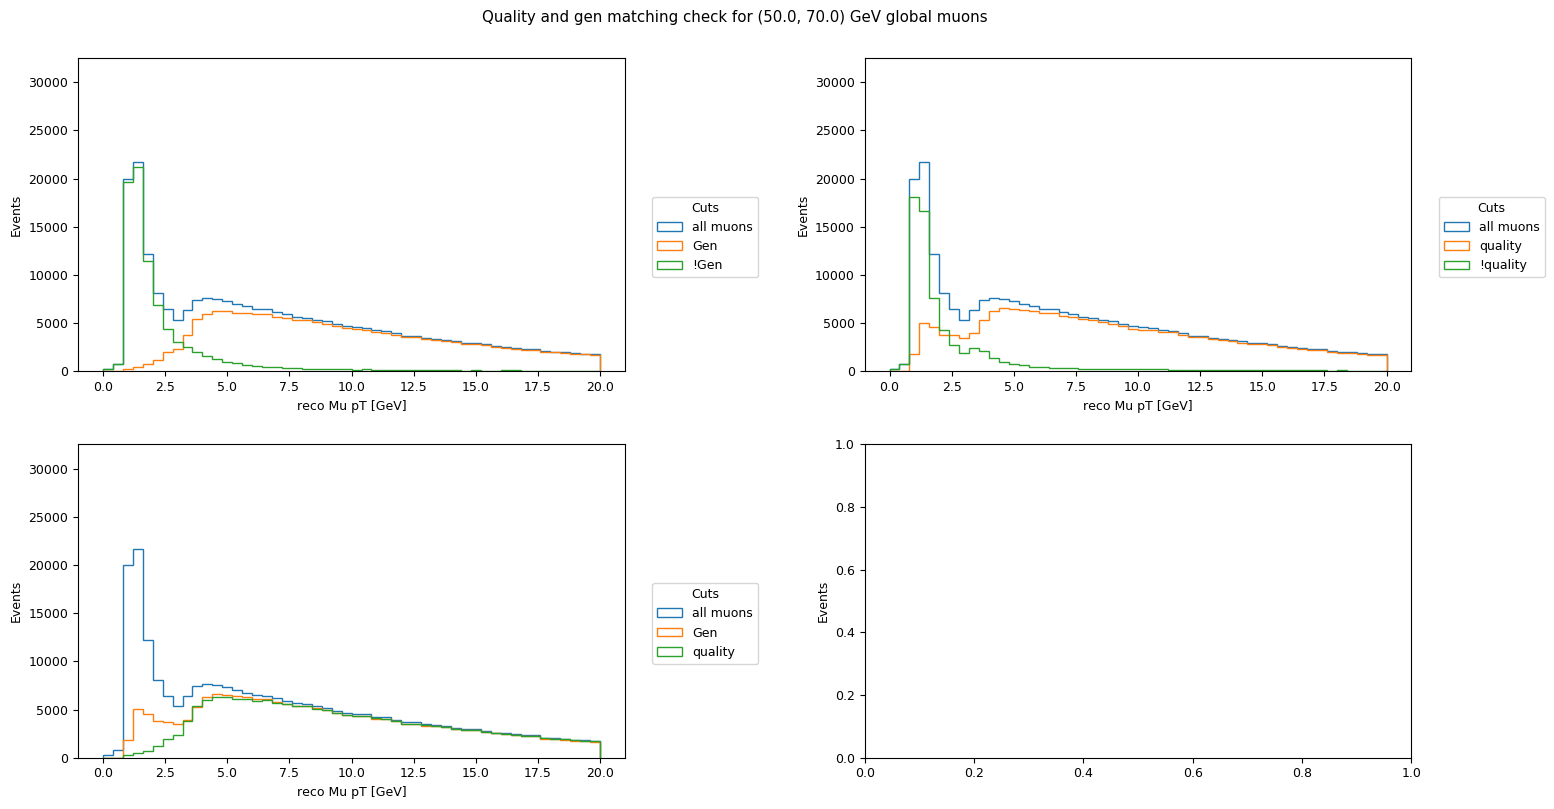

In [13]:
mchi = '60p0'
ctau = 10
### Make subplot axes
fig, axes = plt.subplots(2,2, figsize=(14,8))
plt.tight_layout(h_pad=4.0, w_pad=16.0)
for row in axes:
    for col in row:
        col.set_ylabel('Events')
        
fig.suptitle(f'Quality and gen matching check for {mchis[mchi]} global muons')
fig.subplots_adjust(top=0.92)

genlabels1 = ['all muons','Gen','!Gen']#, 'is gen and quality']   
genlabels2 = ['all muons','quality','!quality']#
genlabels3 = ['all muons','Gen','quality']#
### reco MET pT
axes[0,0].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkgmuons[mchi][ctau]['recoPt'])
data.append(checkgmuons[mchi][ctau][checkgmuons[mchi][ctau]['isGenMatched']==True]['recoPt'])
data.append(checkgmuons[mchi][ctau][checkgmuons[mchi][ctau]['isGenMatched']==False]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[0,0], dict({'range':(0,20)}), labels=genlabels1)


axes[0,1].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkgmuons[mchi][ctau]['recoPt'])
data.append(checkgmuons[mchi][ctau][checkgmuons[mchi][ctau]['qualityTrack']==True]['recoPt'])
data.append(checkgmuons[mchi][ctau][checkgmuons[mchi][ctau]['qualityTrack']==False]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[0,1], dict({'range':(0,20)}), labels=genlabels2)

axes[1,0].set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkgmuons[mchi][ctau]['recoPt'])
data.append(checkgmuons[mchi][ctau][checkgmuons[mchi][ctau]['qualityTrack']==True]['recoPt'])
data.append(checkgmuons[mchi][ctau][checkgmuons[mchi][ctau]['isGenMatched']==True]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes[1,0], dict({'range':(0,20)}), labels=genlabels3)

axes[0,0].legend(loc=(1.05,.3), title='Cuts');
axes[0,1].legend(loc=(1.05,.3), title='Cuts');
axes[1,0].legend(loc=(1.05,.3), title='Cuts');

In [14]:
checkgmuons[mchi][ctau].groupby('entry').nth(0).corr()

,subentry,recoPt,recoEta,recoPhi,recoDxy,recoDz,trackHits,trackPlanes,trackChi2,qualityTrack,isGenMatched,GenDR
subentry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recoPt,NaN,1.000000,0.000976,0.001398,-0.001190,-0.000534,0.008860,0.006177,-0.000238,-0.006236,-0.003779,-0.006017
recoEta,NaN,0.000976,1.000000,0.000718,-0.003050,0.039678,0.006863,0.010884,0.000921,0.004726,0.004370,-0.000833
recoPhi,NaN,0.001398,0.000718,1.000000,-0.010471,-0.003663,-0.000049,0.000374,-0.002946,-0.002169,0.002455,-0.001264
recoDxy,NaN,-0.001190,-0.003050,-0.010471,1.000000,-0.269038,0.006497,0.012712,0.000759,0.009517,0.007780,-0.008135
recoDz,NaN,-0.000534,0.039678,-0.003663,-0.269038,1.000000,0.003935,0.000211,-0.012212,0.006180,0.003973,-0.000411
trackHits,NaN,0.008860,0.006863,-0.000049,0.006497,0.003935,1.000000,0.536307,-0.006946,0.513727,0.391377,-0.354145
trackPlanes,NaN,0.006177,0.010884,0.000374,0.012712,0.000211,0.536307,1.000000,-0.009449,0.624863,0.446645,-0.398000
trackChi2,NaN,-0.000238,0.000921,-0.002946,0.000759,-0.012212,-0.006946,-0.009449,1.000000,-0.009479,-0.009326,0.004043
qualityTrack,NaN,-0.006236,0.004726,-0.002169,0.009517,0.006180,0.513727,0.624863,-0.009479,1.000000,0.623523,-0.548569


## Plot MET and jet variables

# Scratch tests and comparisons

Comparing results before and after fixing Dxy acceptance (i.e. Dxy is a signed distance and can be < 0)

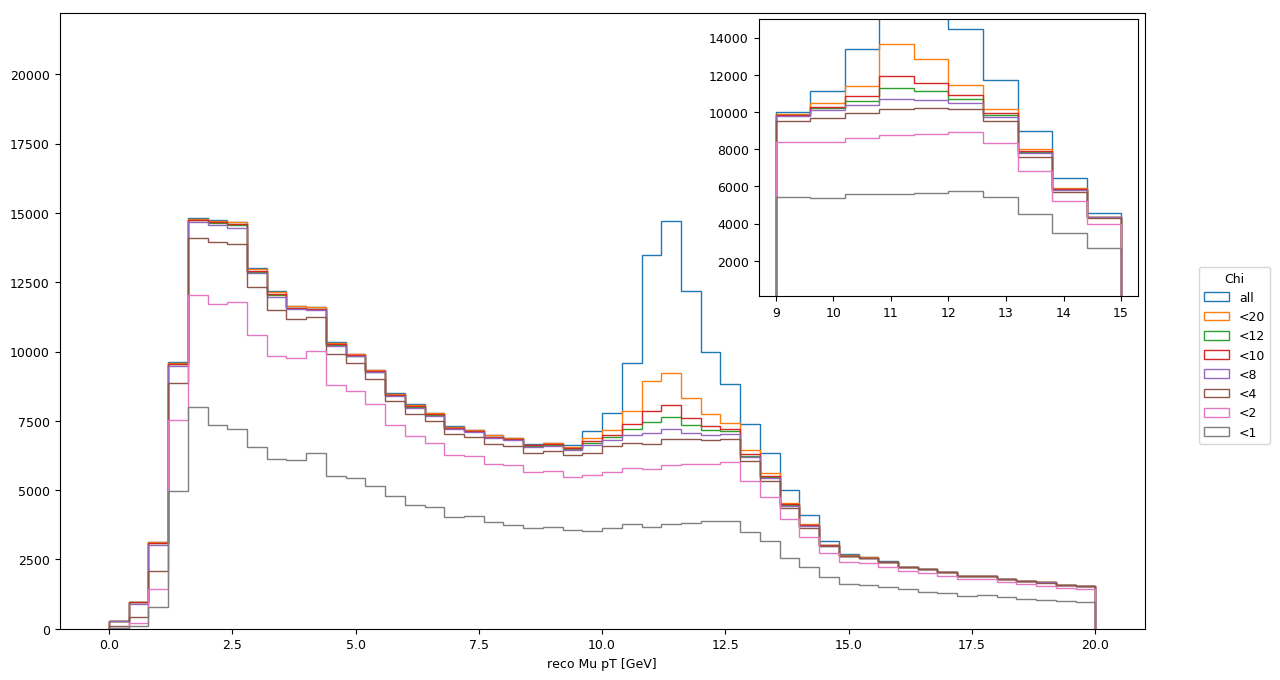

In [15]:
fig, axes = plt.subplots(1,1, figsize=(14,8))
chilabels = ['all','<20','<12','<10','<8','<4','<2','<1']#
axes.set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <20]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <10]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <12]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <8]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <4]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <2]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <1]['recoPt'])

#data.append(checkmuons[mchi][checkmuons[mchi]['trackHits']> 12]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi]['trackPlanes']> 2]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes, dict({'range':(0,20)}),labels=chilabels)
plot_inset(data, axes, dict({'range':(9,15)}))
axes.legend(loc=(1.05,.3), title='Chi');

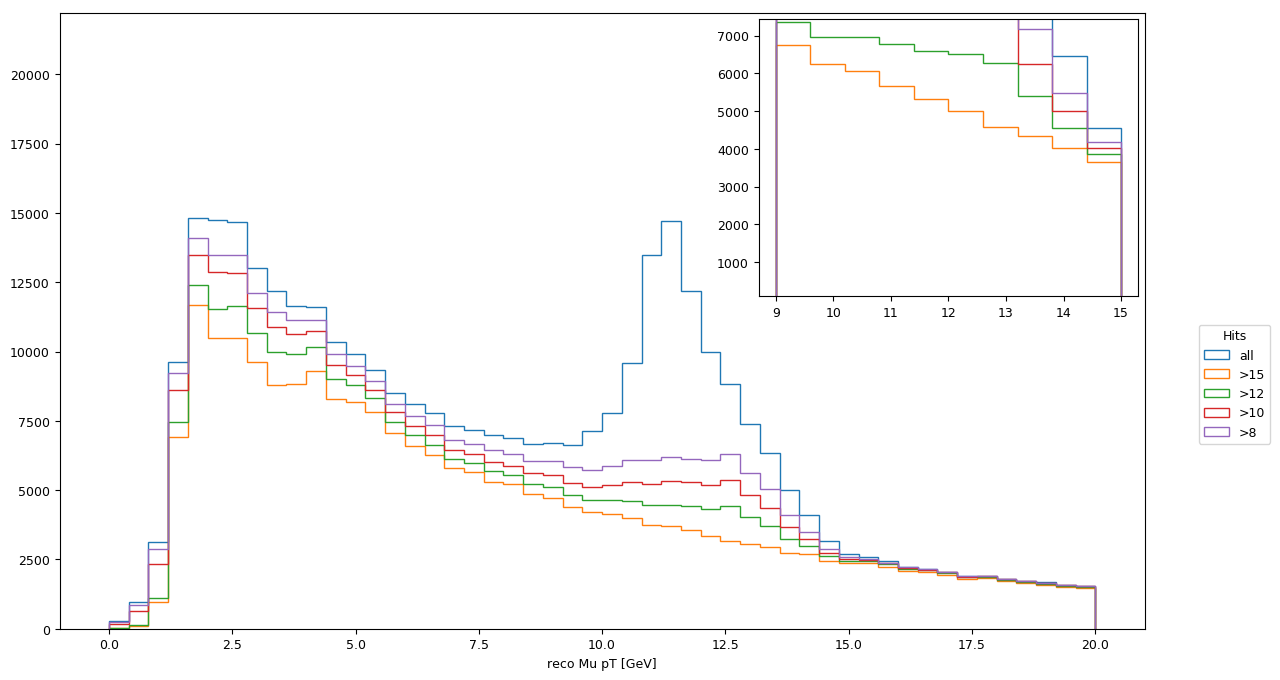

In [16]:
fig, axes = plt.subplots(1,1, figsize=(14,8))
hitlabels = ['all','>15','>12','>10','>8']#
axes.set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >15]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >12]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >10]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >8]['recoPt'])




#data.append(checkmuons[mchi][checkmuons[mchi]['trackHits']> 12]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi]['trackPlanes']> 2]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes, dict({'range':(0,20)}),labels=hitlabels)
plot_inset(data, axes, dict({'range':(9,15)}))

axes.legend(loc=(1.05,.3), title='Hits');

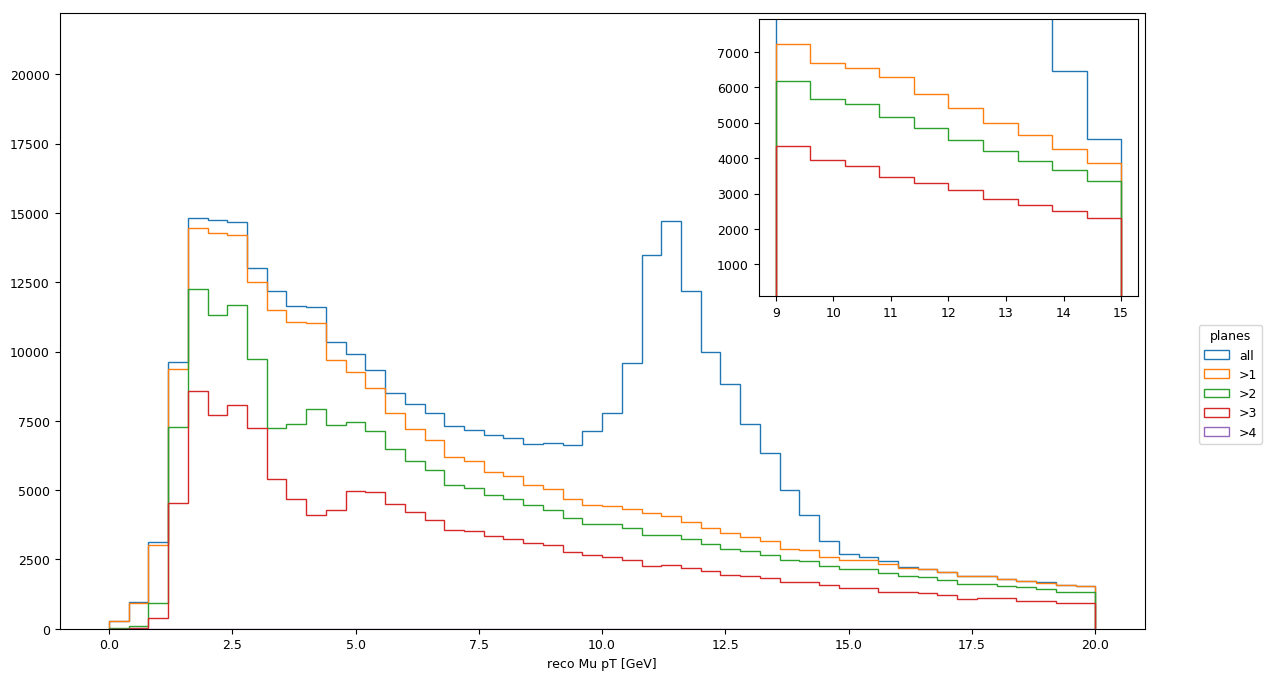

In [17]:
fig, axes = plt.subplots(1,1, figsize=(14,8))
planelabels = ['all','>1','>2','>3','>4']#
axes.set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >1]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >2]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >3]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >4]['recoPt'])




#data.append(checkmuons[mchi][checkmuons[mchi]['trackHits']> 12]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi]['trackPlanes']> 2]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes, dict({'range':(0,20)}),labels=planelabels)
plot_inset(data, axes, dict({'range':(9,15)}))

axes.legend(loc=(1.05,.3), title='planes');

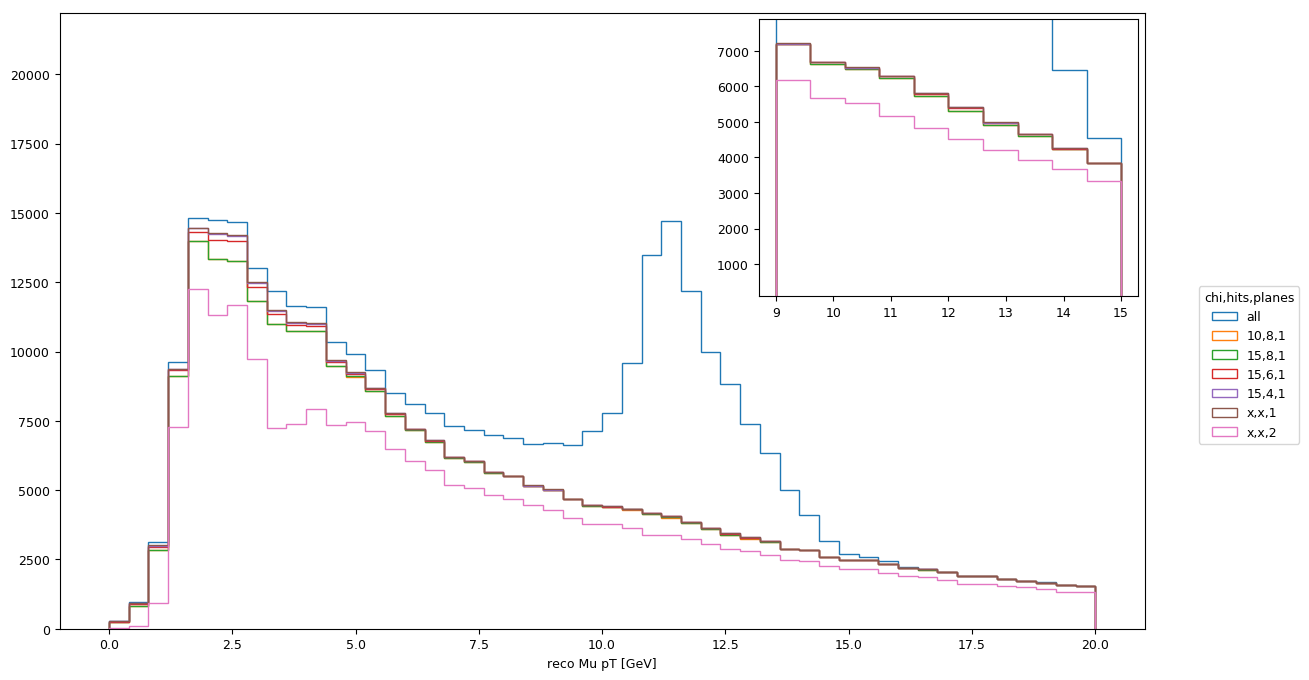

In [18]:
fig, axes = plt.subplots(1,1, figsize=(14,8))
alllabels = ['all','10,8,1','15,8,1','15,6,1','15,4,1','x,x,1','x,x,2']#
axes.set_xlabel('reco Mu pT [GeV]')
data = []
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau]['recoPt'])
data.append(checkmuons[mchi][ctau][(checkmuons[mchi][ctau]['trackChi2'] <10) & (checkmuons[mchi][ctau]['trackHits'] >8) & (checkmuons[mchi][ctau]['trackPlanes'] >1)]['recoPt'])
data.append(checkmuons[mchi][ctau][(checkmuons[mchi][ctau]['trackChi2'] <15) & (checkmuons[mchi][ctau]['trackHits'] >8) & (checkmuons[mchi][ctau]['trackPlanes'] >1)]['recoPt'])
data.append(checkmuons[mchi][ctau][(checkmuons[mchi][ctau]['trackChi2'] <15) & (checkmuons[mchi][ctau]['trackHits'] >6) & (checkmuons[mchi][ctau]['trackPlanes'] >1)]['recoPt'])
data.append(checkmuons[mchi][ctau][(checkmuons[mchi][ctau]['trackChi2'] <15) & (checkmuons[mchi][ctau]['trackHits'] >4) & (checkmuons[mchi][ctau]['trackPlanes'] >1)]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >1]['recoPt'])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >2]['recoPt'])






#data.append(checkmuons[mchi][checkmuons[mchi]['trackHits']> 12]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi]['trackPlanes']> 2]['recoPt'])
#data.append(checkmuons[mchi][checkmuons[mchi][checkmuons[mchi]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes, dict({'range':(0,20)}),labels=alllabels)
plot_inset(data, axes, dict({'range':(9,15)}))

axes.legend(loc=(1.05,.3), title='chi,hits,planes');

IndexError: list index out of range

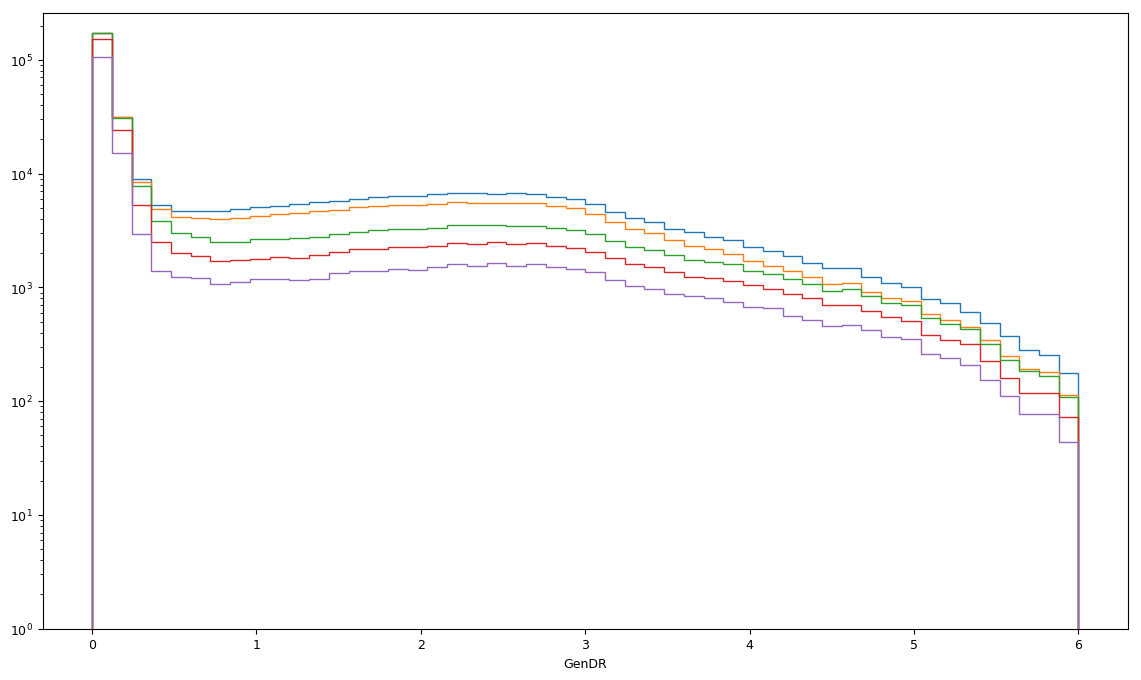

In [19]:
fig, axes = plt.subplots(1,1, figsize=(14,8))
#planelabels = ['all','>1','>2','>3','>4']#
axes.set_xlabel('GenDR')
data = []
variable = 'GenDR'
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >=1][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >1][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >2][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >3][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes'] >4][variable])

#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >15][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >12][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >10][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits'] >8][variable])

#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <20][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <10][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <12][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <8][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <4][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <2][variable])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackChi2'] <1][variable])

#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackHits']> 12]['recoPt'])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes']> 2]['recoPt'])
#data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau][checkmuons[mchi][ctau]['qualityTrack']==True]['qualityTrack']==True]['recoPt'])
plot_full(data, axes, dict({'range':(0,6),'log':True}),labels=planelabels)
plot_inset(data, axes, dict({'range':(0,1.),'log':True}))

axes.legend(loc=(1.05,.3), title='planes');

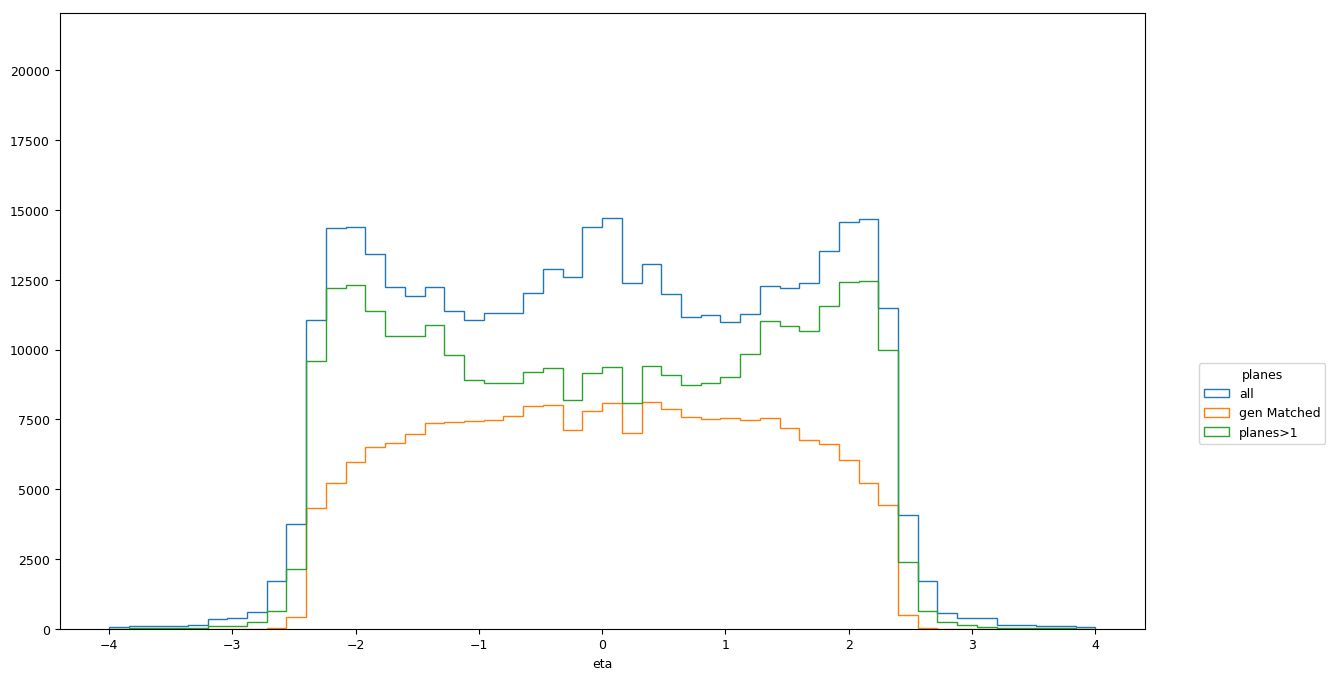

In [20]:
fig, axes = plt.subplots(1,1, figsize=(14,8))
#planelabels = ['all','>1','>2','>3','>4']#
axes.set_xlabel('eta')
data = []
variable = 'recoEta'
#for cut in numCuts:
#    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
data.append(checkmuons[mchi][ctau][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['isGenMatched']==True][variable])
data.append(checkmuons[mchi][ctau][checkmuons[mchi][ctau]['trackPlanes']> 1][variable])

plot_full(data, axes, dict({'range':(-4,4),'log':False}),labels=['all','gen Matched','planes>1'])
#plot_inset(data, axes, dict({'range':(0,1),'log':True}))

axes.legend(loc=(1.05,.3), title='planes');